In [2]:
"""This module contains functions to search an OMLhd sample with Park's (1994) algorithm.

The function optimal_latin_hypercube_sample uses Park's (1994) algorithm to find an
optimal (midpoint) Latin hypercube design. At this point, only the first stage of the
algorithm – finding an optimal midpoint Latin hypercube – is implemented. The second
stage of the algorithm optimally releases each point within its assigned bin. (The
second stage is not yet implemented.)
"""
from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import src.data_generator.latin_hypercubes_aux as aux

# Potential objective functions to serve as criterion of quality of Lhd sample. a-, d-,
# e- and t-optimality functions emphasize in-sample fitting usefulness, while
# g-optimality emphasizes usefulness for prediction.
OPTIMALITY_CRITERIA = {
    "a-optimal": lambda x: np.linalg.inv(x.T @ x).trace(),
    "d-optimal": lambda x: np.linalg.det(np.linalg.inv(x.T @ x)),
    # argmax of minimal eigenvalue = argmin of negative minimal eigenvalue
    "e-optimal": lambda x: np.amin(np.linalg.eig(x.T @ x)[0])* (-1),
    "t-optimal": lambda x: np.trace(x.T @ x) * (-1),
    "g-optimal": lambda x: np.amax(np.diagonal(x @ np.linalg.inv(x.T @ x) @ x.T)),
}


def optimal_latin_hypercube_sample(
    target_n_points,
    dim,
    S_init=None,
    center=None,
    radius=0.5,
    existing_points=None,
    optimality_criterion="d-optimal",
    lhs_design="centered",
    numActive=3,
    numRand=None,
    n_tries=10,
    n_iter=None,
):
    """Generate the optimal (midpoint) Latin hypercube sample (O(M)Lhd).

    This function implements Park's (1994) algorithm for finding an O(M)Lhd either from
    a supplied MLhd, or a randomly generated one. The region of interest is the unit
    cube per default. The algorithm consists of two stages: finding an OMLhd, and in the
    second stage to find an optimal Latin hypercube by releasing the points within their
    optimal bins. (The second stage is not yet implemented).

    In the first stage, two steps are performed: first, the impact of a given number of
    row pairs (rows of the sample S) on the objective function is evaluated, and the
    pairs with the most optimizing impact are selected. In the second step, all
    potential (even-numbered) combinations of columns are evaluated by exchanging their
    values in the given two rows. This is done for all active pairs of rows and repeated
    until the objective function does not change anymore.

    Parameters
    ----------
    target_n_points : int
        Target number of points in the trust region at which criterion
        values are known. The actual number can be larger than this
        if the existing points are badly spaced.
    dim : int
        Number of variables to create.
    S_init : np.ndarray, optional
        An existing midpoint Latin hypercube sample in the region of interested that can
        be used as a starting point for the algorithm. If not specified, a random Lhd
        is generated instead as a starting point.
    center : one-dimensional np.ndarray, optional
        Center of the current trust region. Default is a vector of length 2 with both
        values set to 0.5.
    radius : float, optional
        Radius of the current trust region.
    existing_points : np.ndarray, optional
        2d Array where each row is a parameter vector at which
        the criterion has already been evaluated. This is ignored, if S_0 is provided.
    optimality_criterion : str, optional
        One of "a-optimal", "d-optimal", "e-optimal",
        "t-optimal", "g-optimal".
    lhs_design : str, optional
        One of "centered", "released". "Centered" places points in the middle of each
        bin and finds optimal midpoint Latin hypercube design. "Released" uses a
        Newton-type algorithm to then optimally spread the points within their assigned
        bins.
    numActive : int, optional
        Number of row pairs of S to build and use for exchanging values in their
        columns.
    numRand : int, optional
        Number of random row pairs to try after successful finish of first stage to
        reduce risk of finding a non-optimal OMLhd. Default is 3 * target_n_points // 5.
    n_tries : int, optional
        Number of random MLhds to try out as a starting point of the algorithm. If
        existing_points are supplied, the existing points are used in every try to
        extend them with random points. So the starting points are less random than
        if no existing_points were supplied.
    n_iter : int, optional
        Number of iterations of the algorithm. Default is 100 iterations; for large
        dimensional (> 8) designs, the default is 200 because less costly formulas are
        used, which take longer to converge.

    Returns
    -------
    f : float
        Value of objective function if optimal sample is evaluated.
    S : np.ndarray
        Optimal (midpoint) Latin hypercube sample.
    """
    criterion_func = OPTIMALITY_CRITERIA[optimality_criterion]
    threshold = 8  # my arbitrary choice for too "high-dimensional"
    if (S_init is not None and dim != S_init.shape[1]) or (
        center is not None and dim != len(center)
    ):
        raise ValueError(
            "Dimensions implied by S_init or center contradict dimensions set by dim."
        )
    if center is None:
        center = np.ones(dim) * 0.5
    if numRand is None:
        numRand = 3 * target_n_points // 5
    if n_iter is None:
        if dim < threshold:
            n_iter = 150
        else:
            n_iter = 200

    f_candidates = []
    S_candidates = []

    crit_vals_in_each_iteration = []
    current_best = None
    for t in range(n_tries):
        if t == 0 and S_init is not None:
            S_0 = S_init
        elif existing_points is not None:
            existing_upscaled = aux.scale_up_points(
                existing_points,
                center,
                radius,
                target_n_points,
            )
            empty_bins = aux.get_empty_bin_info(existing_upscaled, target_n_points)
            new = aux.extend_upscaled_lhs_sample(
                empty_bins=empty_bins,
                target_n_points=target_n_points,
                lhs_design="centered",
            )
            S_0 = np.row_stack([existing_upscaled, new])
        else:
            S_0 = aux.create_upscaled_lhs_sample(
                dim=dim,
                n_samples=target_n_points,
                lhs_design="centered",
            )
        current_best = S_0

        crit_vals = []
        for _ in range(n_iter):
            # Step 1
            f_0, active_pairs = _step_1(
                criterion_func=criterion_func, sample=current_best, numActive=numActive
            )

            # Step 2
            f_1, S_1 = _step_2(
                criterion_func=criterion_func,
                dim=dim,
                sample=current_best,
                crit_val=f_0,
                n_pairs=numActive,
                active_pairs=active_pairs,
                threshold=threshold,
            )

            # Check with random pairs that are not the same as the previous active pairs
            potential_random_pairs = np.array(
                list(set(combinations(range(target_n_points), 2)) - set(active_pairs))
            )
            random_pairs = np.random.default_rng().choice(
                a=potential_random_pairs,
                size=numRand,
                replace=False,
                axis=0,
                shuffle=False,  # saves some time and is unnecessary here
            )
            best_crit, current_best = _step_2(
                criterion_func=criterion_func,
                dim=dim,
                sample=S_1,
                crit_val=f_1,
                n_pairs=numRand,
                active_pairs=random_pairs,
                threshold=threshold,
            )

            crit_vals.append(best_crit)

        # Save each critical value to later plot convergence rate
        crit_vals_in_each_iteration.append(crit_vals)

        f_candidates.append(best_crit)
        S_candidates.append(current_best)

    best = np.argmin(f_candidates)

    S_3 = S_candidates[best]

    S = aux.scale_down_points(S_3, center, radius, target_n_points)
    f = criterion_func(S)

    # Second stage of algorithm - Newton-type optimization (with estimagic?)
    if lhs_design == "released":
        pass

    return S, f, crit_vals_in_each_iteration


def _step_1(criterion_func, sample, numActive):
    """
    Implement the first step of the first stage of Park's (1994) algorithm for OMLHD.

    Parameters
    ----------
    criterion_func : function
        Objective function used to evaluate the quality of the Lhd samples.
    sample : np.ndarray
        Initial midpoint Latin hypercube sample to modify by the algorithm.
    numActive : int
        Number of row pairs of S to build and use for exchanging values in their
        columns.

    Returns
    -------
    crit_val : float
        Value of objective function if initial sample is evaluated.
    active_pairs : list of tuples
        List of active row pairs to evaluate in second step.
    """
    crit_val = criterion_func(sample)
    n = len(sample)
    function_values = np.empty(n)
    for i in range(n):
        function_values[i] = criterion_func(np.delete(arr=sample, obj=i, axis=0))
    pairing_candidates = np.argsort(function_values)
    # take the first numActive combinations of the first numActive pairing_candidates
    active_pairs = list(combinations(pairing_candidates[:numActive], 2))[:numActive]

    return crit_val, active_pairs


def _step_2(criterion_func, dim, sample, crit_val, n_pairs, active_pairs, threshold):
    """
    Implement the second step of the first stage of Park's (1994) algorithm for OMLHD.

    Parameters
    ----------
    criterion_func : function
        Objective function used to evaluate the quality of the Lhd samples.
    dim : int
        Number of variables in the design space.
    sample : np.ndarray
        Initial midpoint Latin hypercube sample to modify by the algorithm.
    crit_val : float
        Value of objective function if initial sample is evaluated.
    n_pairs : int
        Number of row pairs of S to build and use for exchanging values in their
        columns.
    active_pairs : list of tuples
        List of row pairs to evaluate in second step.
    threshold : int
        Amount of dimensions deemed too high for regular calculation so easier,
        slower converging formulas are used.

    Returns
    -------
    crit_val : float
        Value of objective function if optimal sample is evaluated.
    sample_winning : np.ndarray
        Optimal (midpoint) Latin hypercube sample.
    """
    it_small_dim = (2 ** (dim - 1)) - 1
    it_large_dim = 2 * dim - 3
    cols_to_consider = dim // 2
    switching_components = []
    # Loop through columns to consider
    for i in range(1, cols_to_consider + 1):
        # Special case: dim is even and i equals columns_to_consider. To avoid overlappings
        if dim % 2 == 0 and i == cols_to_consider:
            curr_combinations = filter(lambda x: 0 in x, combinations(range(dim), i))
        # Regular case: as long as i < columns_to_consider, do this
        else:
            curr_combinations = combinations(range(dim), i)

        # Update switching components list
        switching_components.extend(curr_combinations)
    i = 0
    sample_winning = sample
    while i < n_pairs:
        active_pair = active_pairs[i]
        first_row = active_pair[0]
        second_row = active_pair[1]
        if (
            dim < threshold
        ):  # Arbitrary threshold; for large dim, following calcs are costly
            function_values_step2 = np.empty(it_small_dim)
            for j in range(it_small_dim):
                switching_component = switching_components[j]
                S_temp = sample.copy()
                # try:
                #     function_values_step2[j] = criterion_func(S_temp)
                    # print("First works.")
                # except:
                    # print("First not working.")
                S_temp[([first_row], [second_row]), switching_component] = S_temp[
                    ([second_row], [first_row]), switching_component
                ]
                # try:
                #     function_values_step2[j] = criterion_func(S_temp)
                    # print("Second works.")
                # except:
                    # print("Second not working.")
            winning_switch = switching_components[np.argmin(function_values_step2)]
            S_temp = sample.copy()
            S_temp[([first_row], [second_row]), winning_switch] = S_temp[
                ([second_row], [first_row]), winning_switch
            ]
        else:  # Saves evaluations of crit_val, but needs more iterations
            function_values_step2 = np.empty(it_large_dim)
            for j in range(dim):
                S_temp = sample.copy()
                S_temp[([first_row], [second_row]), j] = S_temp[
                    ([second_row], [first_row]), j
                ]
                function_values_step2[j] = criterion_func(S_temp)
            for j in range(1, dim - 2):
                S_temp = sample.copy()
                S_temp[([first_row], [second_row]), :j] = S_temp[
                    ([second_row], [first_row]), :j
                ]
                function_values_step2[dim + j - 1] = criterion_func(S_temp)
        if criterion_func(S_temp) < crit_val:
            sample_winning = S_temp.copy()
            crit_val, active_pairs = _step_1(
                criterion_func=criterion_func, sample=sample_winning, numActive=n_pairs
            )
            i = 0
            continue
        else:
            i += 1

    return crit_val, sample_winning


In [3]:
full_region, F_crit, crit_val_list = optimal_latin_hypercube_sample(15, 2, optimality_criterion="g-optimal")

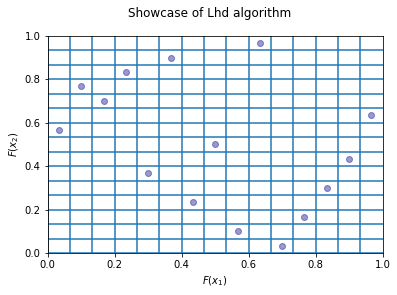

In [4]:
fig, ax = plt.subplots()
fig.suptitle("Showcase of Lhd algorithm")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_ylabel("$F(x_2)$")
ax.set_xlabel("$F(x_1)$")

sns.regplot(
    x=full_region[:, 0],
    y=full_region[:, 1],
    ax=ax,
    fit_reg=False,
    color="darkblue",
    scatter_kws={"alpha": 0.4},
)

n = len(full_region[:, 0])
for i in np.arange(0, 1, 1 / n):
    plt.axhline(i)
    plt.axvline(i)

In [30]:
S = np.array([[1,2], [2,3], [3,1]])
S, S.shape

(array([[1, 2],
        [2, 3],
        [3, 1]]),
 (3, 2))

In [31]:
from scipy.spatial.distance import cdist
cdist(S, S), np.triu(cdist(S, S)), np.max(np.triu(cdist(S, S)))

(array([[0.        , 1.41421356, 2.23606798],
        [1.41421356, 0.        , 2.23606798],
        [2.23606798, 2.23606798, 0.        ]]),
 array([[0.        , 1.41421356, 2.23606798],
        [0.        , 0.        , 2.23606798],
        [0.        , 0.        , 0.        ]]),
 2.23606797749979)